<a href="https://colab.research.google.com/github/siddhant-uniyal/NLP/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Embedding Layer from Scratch


In [3]:
#"embeddings" are called embeddings because the words are "embedded" as fixed points in a continuous vector space. continuous vector means
#the coords are real values , not discrete (0 or 1 like in one hot encoding)
#this is important because coords that are similar correspond to words that are similar. so vectors being close , parallel ,
#antiparallel , etc. actually means something in embeddings. discrete vectors are too
#erratic because they will only have either a 0 or a 1 as a coord value , there wont be any smooth patterns possible
#this is the first diff -> previous embeddings (except w2v) are not created with context in mind. the vectors don't really form desired patterns
#second diff -> no dimensionality compression -> if vocab is of 10k , previous vectors will all be of 10k dimensions (except w2v).
#but embedding of keras can be of specified dimensions

In [3]:
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import  word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot , Tokenizer
from tensorflow.keras.layers import Embedding,Dense,Flatten,GlobalAveragePooling1D,LSTM,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
with open ('/content/gdrive/My Drive/w2v.ob', 'rb') as fp: # from Tokenization project
    corpus = pickle.load(fp)

In [5]:
vocabulary = set()

vocabulary.update(word for list in corpus for word in list)

vocabulary = sorted(list(vocabulary))

vocab_size = len(vocabulary)

print(vocab_size) #same as Tokenization project

89043


In [6]:
OH_rep = [one_hot(' '.join(list) , vocab_size) for list in corpus] #it wants a string

In [8]:
# OH_rep[0] #takes a string -> makes every word it's index in the vocab. so -> "car apple dog" becomes [10 8 19] , car occurs at 10th index in vocab , apple at 8th and dog at 19th

In [7]:
len(OH_rep) #same as number of sentences

49544

In [8]:
print( vocabulary[OH_rep[0][0]] in corpus[0] )  #the reason one_hot is able to work without knowing the actual vocab is it just randomly hashes the word to a number within [1,vocab_size]
#it gave some random index to the first word of the first sentence in the corpus. if we try to check whether this index is random or correct , we get to know that it's random

False


In [9]:
vocabulary[0]

'aa'

In [10]:
#ik max length is 740 from Tokenization project
pre_pad = pad_sequences(OH_rep , padding = "pre" , maxlen = 740)

In [11]:
pre_pad.shape #this is the X for this project. n_samples = 49k and input_shape = (None , 740)

(49544, 740)

In [12]:
post_pad = pad_sequences(OH_rep , padding = "post" , maxlen = 740)

In [13]:
#Embedding layer is nothing but a lookup table of shape (size of vocab , required number of final features )
#so if size of vocab is 100 , and we want 10 to be number of final dimensions , 100x10 matrix would mean that now , every word is of 10 dimensions (every row is of 10 columns) and this is
#true for all the words in the vocab(size number of rows = number of words in vocab)

class CustomEmbeddingLayerRandomInit(tf.keras.layers.Layer): #extends Layer
    def __init__(self, input_dim , output_dim , sequence_length):
        super(CustomEmbeddingLayerRandomInit, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.sequence_length = sequence_length

    def build(self , input_shape = None):
      self.lookup_table = self.add_weight("embedding_matrix", #add_weight is method of tf
                                               shape=(self.input_dim, self.output_dim), #a row for each word , and each row of size we define
                                               initializer="random_normal", #this is causing the embeddings to not make any sense. If I use pre-trained embeddings to initialize the lookup table , the model will set off on the right track.
                                                #rn it starts with random weights and will optimize these random weights , which we don't want.
                                               trainable=True)


    def call(self, input_sequence): #overriding call method of Layer
        input_sequence = tf.cast(input_sequence, "int32")


        return tf.nn.embedding_lookup(self.lookup_table, input_sequence) #w/ tf

In [14]:
dim= 512

In [15]:
model = Sequential([
    CustomEmbeddingLayerRandomInit(vocab_size + 1 , dim , sequence_length = 740),
    Flatten(),
    Dense(1 , activation = "sigmoid")
])

model.build(input_shape = (None , 740))
model.summary()

#so embedding table has 89k rows and 10 columns. but the output will be (740 , 10) , 740 vectors of all the words , each of dimensions = 10

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_embedding_layer_ran  (None, 740, 512)          45590528  
 dom_init (CustomEmbeddingL                                      
 ayerRandomInit)                                                 
                                                                 
 flatten (Flatten)           (None, 378880)            0         
                                                                 
 dense (Dense)               (None, 1)                 378881    
                                                                 
Total params: 45969409 (175.36 MB)
Trainable params: 45969409 (175.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile("adam","bce",["accuracy"])

In [17]:
with open ('/content/gdrive/My Drive/y.ob', 'rb') as fp: #from Tokenization project
    y = pickle.load(fp)

In [18]:
X_train , X_test , y_train , y_test = train_test_split(pre_pad , y , test_size = 0.3 , random_state = 2021)

In [19]:
model.fit(X_train,y_train, epochs=10, verbose=2)

Epoch 1/10
1084/1084 - 75s - loss: 0.3960 - accuracy: 0.8301 - 75s/epoch - 69ms/step
Epoch 2/10
1084/1084 - 31s - loss: 0.0497 - accuracy: 0.9861 - 31s/epoch - 29ms/step
Epoch 3/10
1084/1084 - 22s - loss: 0.0051 - accuracy: 0.9996 - 22s/epoch - 20ms/step
Epoch 4/10
1084/1084 - 19s - loss: 0.0012 - accuracy: 1.0000 - 19s/epoch - 18ms/step
Epoch 5/10
1084/1084 - 18s - loss: 5.2364e-04 - accuracy: 1.0000 - 18s/epoch - 17ms/step
Epoch 6/10
1084/1084 - 18s - loss: 2.6546e-04 - accuracy: 1.0000 - 18s/epoch - 16ms/step
Epoch 7/10
1084/1084 - 17s - loss: 1.4074e-04 - accuracy: 1.0000 - 17s/epoch - 16ms/step
Epoch 8/10
1084/1084 - 17s - loss: 7.6021e-05 - accuracy: 1.0000 - 17s/epoch - 15ms/step
Epoch 9/10
1084/1084 - 16s - loss: 4.1633e-05 - accuracy: 1.0000 - 16s/epoch - 15ms/step
Epoch 10/10
1084/1084 - 16s - loss: 2.3071e-05 - accuracy: 1.0000 - 16s/epoch - 14ms/step


In [20]:
model.evaluate(X_test,y_test,verbose=2)

465/465 - 1s - loss: 0.5002 - accuracy: 0.8832 - 1s/epoch - 2ms/step


[0.5002335906028748, 0.8832077383995056]

In [21]:
embed_layer = model.layers[0].get_weights()[0]
embed_layer.shape

(89044, 512)

In [36]:
# testing whether this embedding layer is able to store proper meaning

vec1 = embed_layer[vocabulary.index("man")]
vec2 = embed_layer[vocabulary.index("male")]

print(1 - spatial.distance.cosine(vec1 , vec2))

# hence , these embeddings dont have any meaning , because they have been initialized randomly. result should have been very close to 1

0.05422476306557655


In [37]:
model = Sequential([
    Embedding(input_dim = vocab_size,output_dim = 10,input_length = 740),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model.compile("adam","bce",["accuracy"])
model.fit(X_train,y_train, epochs=10, verbose=2)



Epoch 1/10
1084/1084 - 116s - loss: 0.4064 - accuracy: 0.8140 - 116s/epoch - 107ms/step
Epoch 2/10
1084/1084 - 29s - loss: 0.2008 - accuracy: 0.9238 - 29s/epoch - 27ms/step
Epoch 3/10
1084/1084 - 17s - loss: 0.1331 - accuracy: 0.9550 - 17s/epoch - 16ms/step
Epoch 4/10
1084/1084 - 14s - loss: 0.0874 - accuracy: 0.9742 - 14s/epoch - 13ms/step
Epoch 5/10
1084/1084 - 11s - loss: 0.0540 - accuracy: 0.9871 - 11s/epoch - 10ms/step
Epoch 6/10
1084/1084 - 8s - loss: 0.0315 - accuracy: 0.9940 - 8s/epoch - 7ms/step
Epoch 7/10
1084/1084 - 8s - loss: 0.0180 - accuracy: 0.9973 - 8s/epoch - 8ms/step
Epoch 8/10
1084/1084 - 8s - loss: 0.0098 - accuracy: 0.9990 - 8s/epoch - 7ms/step
Epoch 9/10
1084/1084 - 7s - loss: 0.0053 - accuracy: 0.9997 - 7s/epoch - 6ms/step
Epoch 10/10
1084/1084 - 5s - loss: 0.0028 - accuracy: 0.9999 - 5s/epoch - 5ms/step


In [38]:
model.evaluate(X_test,y_test,verbose=2)
#accuracies are comparable between embedding layer from scratch and that of keras , because our layer's functionality is very similar to keras's
#embedding layer. also problem of random embeddings will still exist

465/465 - 1s - loss: 0.5377 - accuracy: 0.8716 - 875ms/epoch - 2ms/step


[0.5377461910247803, 0.8715689182281494]

#Text Generation using LSTM

In [39]:
file_path = '/content/gdrive/My Drive/aliceinwonderland.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [40]:
type(text)

str

In [41]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n”“’')
tokenizer.fit_on_texts([text])
vocabulary = tokenizer.word_index #->creates dict of words and their indices in the vocab , cleaning done automatically
vocab_len = len(vocabulary) + 1 #cause 0 index is not reserved to any word. so effective size becomes ogSize + 1

In [42]:
vocabulary

{'the': 1,
 'and': 2,
 'to': 3,
 'a': 4,
 'it': 5,
 'she': 6,
 'i': 7,
 'of': 8,
 'said': 9,
 'you': 10,
 'alice': 11,
 'in': 12,
 'was': 13,
 'that': 14,
 'as': 15,
 'her': 16,
 't': 17,
 'at': 18,
 's': 19,
 'on': 20,
 'with': 21,
 'all': 22,
 'had': 23,
 'but': 24,
 'for': 25,
 'so': 26,
 'they': 27,
 'be': 28,
 'very': 29,
 'not': 30,
 'what': 31,
 'this': 32,
 'little': 33,
 'he': 34,
 'out': 35,
 'down': 36,
 'one': 37,
 'is': 38,
 'up': 39,
 'there': 40,
 'his': 41,
 'about': 42,
 'if': 43,
 'then': 44,
 'no': 45,
 'like': 46,
 'were': 47,
 'would': 48,
 'went': 49,
 'herself': 50,
 'them': 51,
 'again': 52,
 'know': 53,
 'do': 54,
 'have': 55,
 'when': 56,
 'could': 57,
 'queen': 58,
 'or': 59,
 'thought': 60,
 'off': 61,
 'time': 62,
 'me': 63,
 'into': 64,
 'see': 65,
 'how': 66,
 'king': 67,
 'who': 68,
 'did': 69,
 'your': 70,
 'can': 71,
 'm': 72,
 'well': 73,
 'don': 74,
 'turtle': 75,
 'by': 76,
 'began': 77,
 'my': 78,
 'now': 79,
 'mock': 80,
 'its': 81,
 'll': 82,
 'a

In [43]:
vocab_len

2760

In [44]:
input_sequences = []

for line in text.split('\n'):
    token_list = [token for list in tokenizer.texts_to_sequences([line]) for token in list]
    input_sequences.extend([token_list[i:j] for i in range(len(token_list)) for j in range(i + 1, len(token_list) + 1)])

# len(input_sequences)
# input_sequences[0]

The input_sequences list you got has n-grams of variable length, which isin't very good for training, so we pad the sequences to make them equal in length.

In [45]:
max_sequence_length = max(len(list) for list in input_sequences)
generate_len =  int(np.median([len(list) for list in input_sequences]))#length of generated text should be roughly the median of lengths of all sentences in dataset
input_sequences = np.array(pad_sequences(input_sequences , padding = "pre" , maxlen = max_sequence_length))

# max_sequence_length
# input_sequences.shape -> all possible n grams = shape[0] , each n gram padded to shape[1] regardless of n
# input_sequences[0]

In [46]:
X, y = input_sequences[:,:-1] , input_sequences[:,-1]

In [47]:
# len(X)
# len(y)

In [48]:
# X[0]
# y[0]

In [49]:
y = to_categorical(y)

In [50]:
y.shape # -> since vocab_len = 2760

(183710, 2760)

In [51]:
model = Sequential([
    Embedding(input_dim = vocab_len , output_dim =  50 , input_length =  max_sequence_length - 1 ),
    LSTM(100),
    Dense(vocab_len , activation = "softmax")
])

model.compile('adam' , 'categorical_crossentropy' , ['accuracy']) #->multi class binary label so cce

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 17, 50)            138000    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 2760)              278760    
                                                                 
Total params: 477160 (1.82 MB)
Trainable params: 477160 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model.fit(X, y, epochs=50,verbose=2)  #keeps crashing but loss is decreasing steadily so it's mostly correct

Epoch 1/50
5741/5741 - 46s - loss: 5.4194 - accuracy: 0.1023 - 46s/epoch - 8ms/step
Epoch 2/50
5741/5741 - 31s - loss: 4.4484 - accuracy: 0.1821 - 31s/epoch - 5ms/step
Epoch 3/50
5741/5741 - 32s - loss: 3.8732 - accuracy: 0.2504 - 32s/epoch - 6ms/step
Epoch 4/50
5741/5741 - 30s - loss: 3.4417 - accuracy: 0.3192 - 30s/epoch - 5ms/step
Epoch 5/50
5741/5741 - 31s - loss: 3.1201 - accuracy: 0.3798 - 31s/epoch - 5ms/step
Epoch 6/50
5741/5741 - 30s - loss: 2.8744 - accuracy: 0.4284 - 30s/epoch - 5ms/step
Epoch 7/50
5741/5741 - 32s - loss: 2.6828 - accuracy: 0.4690 - 32s/epoch - 5ms/step
Epoch 8/50
5741/5741 - 31s - loss: 2.5299 - accuracy: 0.5023 - 31s/epoch - 5ms/step
Epoch 9/50
5741/5741 - 31s - loss: 2.4079 - accuracy: 0.5271 - 31s/epoch - 5ms/step
Epoch 10/50
5741/5741 - 31s - loss: 2.3105 - accuracy: 0.5468 - 31s/epoch - 5ms/step
Epoch 11/50
5741/5741 - 31s - loss: 2.2288 - accuracy: 0.5639 - 31s/epoch - 5ms/step
Epoch 12/50
5741/5741 - 31s - loss: 2.1623 - accuracy: 0.5771 - 31s/epoch 

In [54]:
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n”“’')
def generate_text(seed_text, next_words, model, max_sequence_len):
    tokenizer1.fit_on_texts([seed_text])
    for _ in range(next_words):
        sequence = tokenizer1.texts_to_sequences([seed_text])

        sequence = pad_sequences(sequence , padding = "pre" , maxlen = max_sequence_length - 1)
        predicted_probs = model.predict(sequence, verbose=0)
        predicted = np.argmax(predicted_probs)

        output_word =  [key for key in vocabulary if vocabulary[key] == predicted][0]
        seed_text += " " + output_word
    return seed_text

generated_text = generate_text("Alice was", generate_len , model, max_sequence_length)
print(generated_text)

Alice was butter butter butter butter


# Question Answering using RNN




In [55]:
df = pd.read_csv('/content/gdrive/My Drive/ques_ans.csv')

In [56]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [57]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


In [58]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [59]:
df.dropna(inplace = True)

In [60]:
context_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n”“’')

context_tokenizer.fit_on_texts(df['text'])

context = context_tokenizer.texts_to_sequences(df['text'])

answers = context_tokenizer.texts_to_sequences(df['selected_text']) # -> works cause selected text is subset of text so fitted tokenizer knows what's in it

beg_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)] #-> taking pairs of context and answers. iterating over each character of a , and saying
#that , if x se leke x + len(b) (subarray of size len(b)) is b , then that x is the starting of b
end_pos = [[1 if a[x -len(b) + 1 : x + 1] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)] #if x- len(b) se leke x is b , then x is ending pos of b

In [61]:
# beg_pos[2]
# end_pos[2]
#so it's correct

In [62]:
context = np.array(pad_sequences(context, maxlen = 36, padding='post', truncating='post'))
beg_pos = np.array(pad_sequences(beg_pos , maxlen = 36 , padding = "post"))
end_pos = np.array(pad_sequences(end_pos , maxlen = 36 , padding = "post"))

zero_rows = np.all(beg_pos == 0 , axis = 1)

context , beg_pos , end_pos = context[~zero_rows] , beg_pos[~zero_rows] , end_pos[~zero_rows]

beg_pos = np.expand_dims(beg_pos, axis=2)
end_pos = np.expand_dims(end_pos, axis=2)

ans_vec = np.concatenate((beg_pos, end_pos), axis=2)

context.shape, beg_pos.shape, end_pos.shape, ans_vec.shape

((26235, 36), (26235, 36, 1), (26235, 36, 1), (26235, 36, 2))

In [63]:
question_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n”“’')
question_tokenizer.fit_on_texts(df.sentiment.fillna(''))
question = question_tokenizer.texts_to_sequences(df.sentiment.fillna(''))
question = np.array(pad_sequences(question , maxlen = 36 , padding = "post"))
question = question[~zero_rows]

question.shape

(26235, 36)

In [64]:
X1_train , X1_test , X2_train , X2_test , y_train , y_test = train_test_split(context , question , ans_vec , test_size = 0.3 , random_state = 2021)

X1_train.shape , X1_test.shape , X2_train.shape , X2_test.shape , y_train.shape , y_test.shape

((18364, 36),
 (7871, 36),
 (18364, 36),
 (7871, 36),
 (18364, 36, 2),
 (7871, 36, 2))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 36)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 36)]                 0         []                            
                                                                                                  
 context_embeddings (Embedd  (None, 36, 64)               1702336   ['input_1[0][0]']             
 ing)                                                                                             
                                                                                                  
 question_embeddings (Embed  (None, 36, 64)               256       ['input_2[0][0]']         

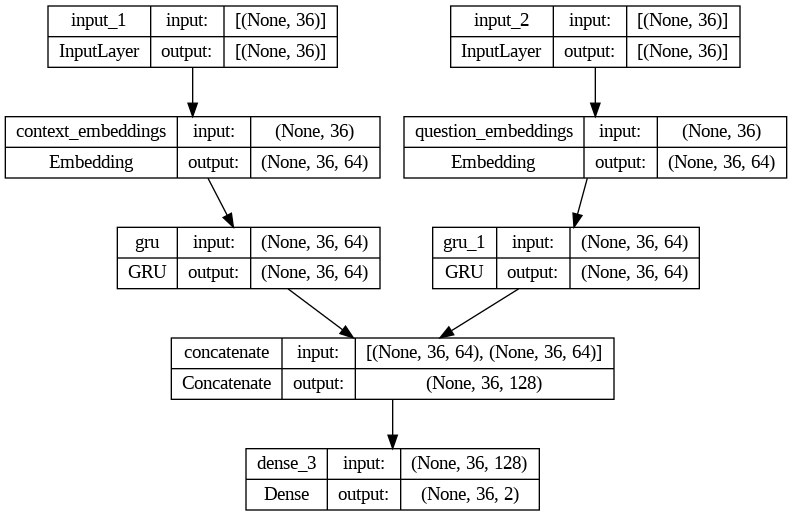

In [65]:
from tensorflow import keras
from tensorflow.keras import layers as L

EMBED_DIM = 64
N_REC = 64
timesteps = question.shape[0] #->basically just number of sentences
context_inp = L.Input(shape = (36))
context_emb = L.Embedding(len(context_tokenizer.word_index)+1, EMBED_DIM, name='context_embeddings')(context_inp)
question_inp = L.Input(shape = (36))
question_emb = L.Embedding(len(question_tokenizer.word_index)+1, EMBED_DIM, name='question_embeddings')(question_inp)


context_gru = L.GRU(N_REC , return_sequences = True)(context_emb)
question_gru = L.GRU(N_REC , return_sequences = True)(question_emb)

concat_emb = L.Concatenate(axis = -1)([context_gru, question_gru])

outputs = L.Dense(2)(concat_emb)


model = keras.Model(inputs=[context_inp, question_inp], outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4) , metrics = ['accuracy'])
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [66]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

history = model.fit([X1_train , X2_train] , y_train , epochs = 25 , validation_data=([X1_test, X2_test], y_test) , callbacks = [es , rlp])

Epoch 1/25
574/574 [==============================] - 32s 43ms/step - loss: 0.1204 - accuracy: 0.5718 - val_loss: 0.0981 - val_accuracy: 0.6607 - lr: 1.0000e-04
Epoch 2/25
574/574 [==============================] - 10s 18ms/step - loss: 0.0954 - accuracy: 0.7124 - val_loss: 0.0953 - val_accuracy: 0.9331 - lr: 1.0000e-04
Epoch 3/25
574/574 [==============================] - 7s 13ms/step - loss: 0.0880 - accuracy: 0.7529 - val_loss: 0.0851 - val_accuracy: 0.7055 - lr: 1.0000e-04
Epoch 4/25
574/574 [==============================] - 8s 15ms/step - loss: 0.0807 - accuracy: 0.7476 - val_loss: 0.0827 - val_accuracy: 0.7245 - lr: 1.0000e-04
Epoch 5/25
574/574 [==============================] - 9s 15ms/step - loss: 0.0777 - accuracy: 0.7621 - val_loss: 0.0798 - val_accuracy: 0.7546 - lr: 1.0000e-04
Epoch 6/25
574/574 [==============================] - 7s 12ms/step - loss: 0.0718 - accuracy: 0.7613 - val_loss: 0.0807 - val_accuracy: 0.7588 - lr: 1.0000e-04
Epoch 7/25
570/574 [==================

In [ ]:
def predict_custom_input(custom_context, custom_question):
    custom_context_seq = context_tokenizer.texts_to_sequences([custom_context])
    custom_context_padded = np.array(pad_sequences(custom_context_seq, maxlen=36, padding='post', truncating='post'))

    custom_question_seq = question_tokenizer.texts_to_sequences([custom_question])
    custom_question_padded = np.array(pad_sequences(custom_question_seq, maxlen=36, padding='post', truncating='post'))

    predictions = model.predict([custom_context_padded, custom_question_padded])

    pred_ans_beg, pred_ans_end = np.ravel(predictions.argmax(axis=1))

    pred_answer_text = context_tokenizer.sequences_to_texts([custom_context_padded[0][pred_ans_beg: pred_ans_end+1]])

    print('Custom Input:')
    print('Context:', custom_context)
    print('Question:', custom_question)
    print('Predicted Answer:', pred_answer_text)

custom_context_input = input("Your custom context goes here.")
custom_question_input = input("Your custom question goes here.")
predict_custom_input(custom_context_input, custom_question_input)
